# (Extra) Linear Regression: Feature Engineering

This notebook is more advanced. It shows a `linear model` with `data cleaning` and `feature engineering`.

We do the following feature engineering:

1. We use the hierarchical structure of the zip code in switzerland (See [Wikipedia](https://en.wikipedia.org/wiki/Postal_codes_in_Switzerland_and_Liechtenstein)) to create 3 new features: `zipcode_3`.
2. We use the `SqrtTransformer` transformer to generate a new feature e.g. `living_area_sqrt`.

Other feature engineerings are possible. For example, we could use the `municipality_name` to create a new feature `municipality_population`.

In [1]:
import pandas as pd
import numpy as np
from sklearn.model_selection import train_test_split
import matplotlib.pyplot as plt
from sklearn.compose import TransformedTargetRegressor
from sklearn.model_selection import cross_val_predict
from sklearn.preprocessing import PolynomialFeatures
import seaborn as sns

# Prepare data

In [2]:
# Load the train data
train_data = pd.read_csv('../data/houses_train.csv', index_col=0)

print(train_data.columns)

Index(['lat', 'long', 'zipcode', 'municipality_name', 'build_year',
       'object_type_name', 'living_area', 'num_rooms', 'water_percentage_1000',
       'travel_time_private_transport', 'travel_time_public_transport',
       'number_of_buildings_in_hectare', 'number_of_apartments_in_hectare',
       'number_of_workplaces_in_hectare',
       'number_of_workplaces_sector_1_in_hectare',
       'number_of_workplaces_sector_2_in_hectare',
       'number_of_workplaces_sector_3_in_hectare', 'population_in_hectare',
       'price'],
      dtype='object')


In [3]:
# Split data into features and labels.
X_data = train_data.drop(columns='price')
y_data = train_data['price']

print(X_data.shape)

(20313, 18)


In [4]:
# Split features and labels into train (X_train, y_train) and validation set (X_val, y_val).
X_train, X_val, y_train, y_val = train_test_split(X_data, y_data, stratify=X_data['object_type_name'], test_size=0.1)

# ValueClipper and RoomCleaner

We use the `ValueClipper` and `RoomCleaner` from `5_linear_regression-outliers.ipynb`.

In [5]:
from sklearn.linear_model import LinearRegression
from sklearn.preprocessing import OneHotEncoder
from sklearn.compose import make_column_transformer
from sklearn.pipeline import Pipeline

In [6]:
from sklearn.base import BaseEstimator, TransformerMixin
class ValueClipper(BaseEstimator, TransformerMixin):
    def __init__(self, column, min_threshold, max_threshold):
        self.column = column
        self.min_threshold = min_threshold
        self.max_threshold = max_threshold

    def fit(self, X, y=None):
        return self

    def transform(self, X, y=None):
        X = X.copy()
        X.loc[X[self.column] < self.min_threshold, self.column] = self.min_threshold
        X.loc[X[self.column] > self.max_threshold, self.column] = self.max_threshold
        return X

In [7]:
class RoomCleaner(BaseEstimator, TransformerMixin):

    def __init__(self):
        pass

    def fit(self, X, y=None):
        return self

    def transform(self, X, y=None):
        X = X.copy()
        X.loc[X.living_area / X.num_rooms < 5, 'num_rooms'] /= 10
        return X

# ZipcodeEngineering

This transformer does step 1. from the intro text.
It creates new features  `zipcode_1`, `zipcode_2`, `zipcode_3` (the leading number(s) of the zipcodes) based on the existing feature `zipcode`.

In [8]:
class ZipcodeEngineering(BaseEstimator, TransformerMixin):
    def __init__(self):
        pass

    def fit(self, X, y=None):
        return self

    def transform(self, X, y=None):
        X = X.copy()
        X['zipcode_3'] = X['zipcode'] // 10  # e.g. 4106 -> 410
        X['zipcode_2'] = X['zipcode'] // 100  # e.g. 4106 -> 41
        X['zipcode_1'] = X['zipcode'] // 1000   # e.g. 4106 -> 4
        return X

In [9]:
class SqrtTransformer(BaseEstimator, TransformerMixin):
    def __init__(self, degree: int=2):
        super().__init__()
        self.degree = degree
        
    def fit(self, X, y=None):
        return self

    def transform(self, X):
        X = X.copy()
        for col in X.columns:
            for d in range(1, self.degree + 1):
                new_col_name = f"{col}_sqrt_{d}"
                X[new_col_name] = X[col] ** (1 / (2 ** d))
        return X

# Metrik

In [10]:
def mean_absolute_percentage_error(y_true, y_pred):
    return np.mean(np.abs((y_true - y_pred) / y_true)) * 100

## Model with Feature Engineering

Let's build the final model with the new features


In [11]:
model = Pipeline([
    ('pre_zip', ZipcodeEngineering()),
    ('pre_by_vc', ValueClipper('build_year', 1900, 2020)),
    ('pre_rc', RoomCleaner()),
    ('pre_ohe', make_column_transformer(
        (OneHotEncoder(handle_unknown='ignore'), ['zipcode_3', 'object_type_name']),
        (SqrtTransformer(degree=2), ['living_area']),
        (SqrtTransformer(degree=2), ['travel_time_private_transport']),
        (SqrtTransformer(degree=2), ['travel_time_public_transport']),
        ('passthrough', ['build_year']),
        remainder='drop'
    )),
    ('reg', LinearRegression())
])

y_data_hat = cross_val_predict(model, X_data, y_data, cv=5)
print(mean_absolute_percentage_error(y_data, y_data_hat))

27.06268124650788


# Output Variable Transformation

Let's check the residuals with the Tukey-Anscombe Plot.

Given the increasing spread of the `residuals`, a `log` transformation on `price` seems promising.

External resource: https://www.codecademy.com/article/data-transformations-for-multiple-linear-regression

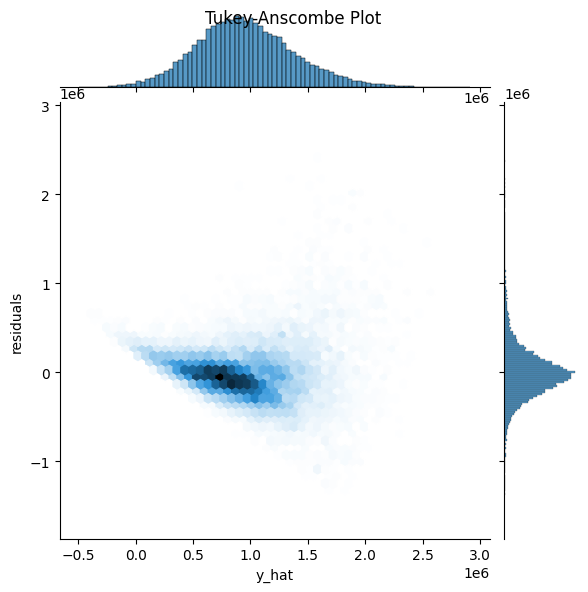

In [12]:
p = sns.jointplot(
    data=pd.DataFrame(dict(
        y_hat=y_data_hat,
        residuals=y_data - y_data_hat
    )),
    x='y_hat',
    y='residuals',
    kind='hex',
)
p.fig.suptitle('Tukey-Anscombe Plot')
plt.show()

Let's do the `log` transformation. With the `TransformedTargetRegressor` we can add it right into the Pipeline.

In [13]:
model = Pipeline([
    ('pre_zip', ZipcodeEngineering()),
    ('pre_by_vc', ValueClipper('build_year', 1900, 2020)),
    ('pre_rc', RoomCleaner()),
    ('pre_ohe', make_column_transformer(
        (OneHotEncoder(handle_unknown='ignore'), ['zipcode_3', 'object_type_name']),
        (SqrtTransformer(degree=2), ['living_area']),
        (SqrtTransformer(degree=2), ['travel_time_private_transport']),
        (SqrtTransformer(degree=2), ['travel_time_public_transport']),
        ('passthrough', ['build_year']),
        remainder='drop'
    )
     ),
    ('reg', TransformedTargetRegressor(
        regressor=LinearRegression(),
        func=np.log,
        inverse_func=np.exp,
    ))
])

y_data_hat = cross_val_predict(model, X_data, y_data, cv=5)
print(mean_absolute_percentage_error(y_data, y_data_hat))

20.878855375587253


The MAPE on the validation data is around 23%.

Note that we *only* use the `living_area`, the first 3 digits of the `zipcode` and the `object_type_name` for this model.

## Sanity checking the Tukey-Anscombe Plot (after Transformation)

Now the Tukey-Anscombe Plot looks better. The residuals are centered around 0 and have more of a constant spread.

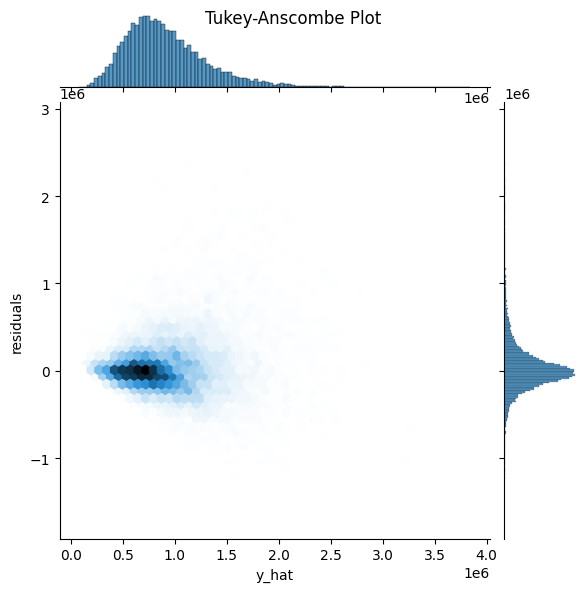

In [14]:
import seaborn as sns

p = sns.jointplot(
    data=pd.DataFrame(dict(
        y_hat=y_data_hat,
        residuals=y_data - y_data_hat
    )),
    x='y_hat',
    y='residuals',
    kind="hex"
)
p.fig.suptitle('Tukey-Anscombe Plot')
plt.show()

Note that it may also could make sense to use the `MAPE` to train the linear model rather than then `MSE`, however, this is not implemented in `sklearn` yet.

## (Extra) Learning Curve

With the learning curve we can analyse if the model needs more data or we have sufficient data.

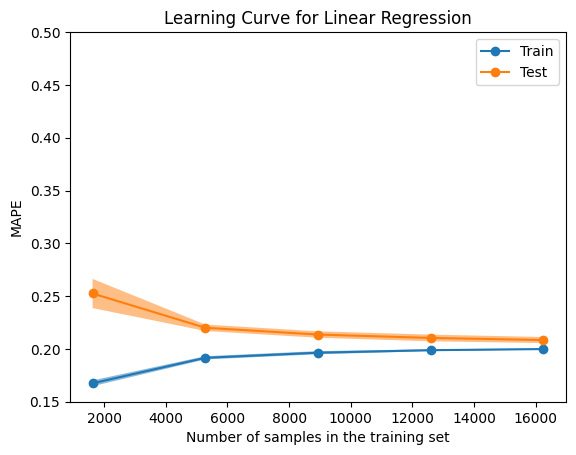

In [15]:
import matplotlib.pyplot as plt
from sklearn.model_selection import LearningCurveDisplay, ShuffleSplit

common_params = {
    "X": X_data,
    "y": y_data,
    "train_sizes": np.linspace(0.1, 1.0, 5),
    "cv": ShuffleSplit(n_splits=5, test_size=0.2, random_state=42),
    "score_type": "both",
    "n_jobs": 4,
    "line_kw": {"marker": "o"},
    "std_display_style": "fill_between",
    "score_name": "MAPE",
}
lcd = LearningCurveDisplay.from_estimator(model, **common_params, scoring='neg_mean_absolute_percentage_error', negate_score=True)
lcd.ax_.set_ylim(ymin=0.15, ymax=0.5)
plt.title("Learning Curve for Linear Regression")
plt.show()

<a style='text-decoration:none;line-height:16px;display:flex;color:#5B5B62;padding:10px;justify-content:end;' href='https://deepnote.com?utm_source=created-in-deepnote-cell&projectId=7f832b5b-4e3b-4502-b254-1ce36bd320ed' target="_blank">
 </img>
Created in <span style='font-weight:600;margin-left:4px;'>Deepnote</span></a>